# Implementing a Multilayer Perceptron (MNIST)

## 1) Installing Libraries

In [1]:
# !conda install numpy pandas matplotlib --yes

In [4]:
# !pip install torch torchvision torchaudio

In [5]:
# !conda install watermark

In [6]:
%load_ext watermark
%watermark -v -p numpy,pandas,matplotlib,torch

Python implementation: CPython
Python version       : 3.9.17
IPython version      : 8.14.0

numpy     : 1.25.0
pandas    : 1.5.3
matplotlib: 3.7.1
torch     : 2.0.1



## 2) Loading the dataset

- MNIST website: http://yann.lecun.com/exdb/mnist/

In [7]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

train_dataset = datasets.MNIST(
    root="./mnist", train=True, transform=transforms.ToTensor(), download=True
)

test_dataset = datasets.MNIST(
    root="./mnist", train=False, transform=transforms.ToTensor()
)

100.0%


Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw



100.0%


Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



100.0%


Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw



100.0%

Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



In [8]:
len(train_dataset)

60000

In [9]:
len(test_dataset)

10000

### Create a validation set

In [10]:
import torch
from torch.utils.data.dataset import random_split

torch.manual_seed(1)
train_dataset, val_dataset = random_split(train_dataset, lengths=[55000, 5000])

In [11]:
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=64,
    shuffle=True,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=64,
    shuffle=False,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=64,
    shuffle=False,
)

## 3) Implementing the model

In [28]:
import torch

class PyTorchMLP(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()

        self.all_layers = torch.nn.Sequential(
            # 1st hidden layer
            torch.nn.Linear(num_features, 50),
            torch.nn.ReLU(),
            # 2nd hidden layer
            # torch.nn.Linear(50, 25),
            # torch.nn.ReLU(),
            # output layer
            torch.nn.Linear(50, num_classes),
        )

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        logits = self.all_layers(x)
        return logits

## 4) The training loop

In [29]:
def compute_accuracy(model, dataloader):

    model = model.eval()

    correct = 0.0
    total_examples = 0

    for idx, (features, labels) in enumerate(dataloader):

        with torch.no_grad():
            logits = model(features)

        predictions = torch.argmax(logits, dim=1)

        compare = labels == predictions
        correct += torch.sum(compare)
        total_examples += len(compare)

    return correct / total_examples

In [30]:
import torch.nn.functional as F

torch.manual_seed(1)
model = PyTorchMLP(num_features=784, num_classes=10)

optimizer = torch.optim.SGD(model.parameters(), lr=0.05)

num_epochs = 10

loss_list = []
train_acc_list, val_acc_list = [], []
for epoch in range(num_epochs):

    model = model.train()
    for batch_idx, (features, labels) in enumerate(train_loader):

        logits = model(features)

        loss = F.cross_entropy(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if not batch_idx % 250:
            ### LOGGING
            print(
                f"Epoch: {epoch+1:03d}/{num_epochs:03d}"
                f" | Batch {batch_idx:03d}/{len(train_loader):03d}"
                f" | Train Loss: {loss:.2f}"
            )
        loss_list.append(loss.item())

    train_acc = compute_accuracy(model, train_loader)
    val_acc = compute_accuracy(model, val_loader)
    print(f"Train Acc {train_acc*100:.2f}% | Val Acc {val_acc*100:.2f}%")
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)

Epoch: 001/010 | Batch 000/860 | Train Loss: 2.32
Epoch: 001/010 | Batch 250/860 | Train Loss: 0.69
Epoch: 001/010 | Batch 500/860 | Train Loss: 0.42
Epoch: 001/010 | Batch 750/860 | Train Loss: 0.39
Train Acc 90.73% | Val Acc 90.72%
Epoch: 002/010 | Batch 000/860 | Train Loss: 0.38
Epoch: 002/010 | Batch 250/860 | Train Loss: 0.21
Epoch: 002/010 | Batch 500/860 | Train Loss: 0.21
Epoch: 002/010 | Batch 750/860 | Train Loss: 0.30
Train Acc 92.17% | Val Acc 91.74%
Epoch: 003/010 | Batch 000/860 | Train Loss: 0.44
Epoch: 003/010 | Batch 250/860 | Train Loss: 0.31
Epoch: 003/010 | Batch 500/860 | Train Loss: 0.20
Epoch: 003/010 | Batch 750/860 | Train Loss: 0.22
Train Acc 93.32% | Val Acc 92.84%
Epoch: 004/010 | Batch 000/860 | Train Loss: 0.41
Epoch: 004/010 | Batch 250/860 | Train Loss: 0.08
Epoch: 004/010 | Batch 500/860 | Train Loss: 0.18
Epoch: 004/010 | Batch 750/860 | Train Loss: 0.27
Train Acc 93.80% | Val Acc 93.30%
Epoch: 005/010 | Batch 000/860 | Train Loss: 0.26
Epoch: 005/010

## 7) Evaluating the results

In [31]:
'''show model parameters number'''  
print(sum(p.numel() for p in model.parameters()))

39760


In [32]:
train_acc = compute_accuracy(model, train_loader)
val_acc = compute_accuracy(model, val_loader)
test_acc = compute_accuracy(model, test_loader)

print(f"Train Acc {train_acc*100:.2f}%")
print(f"Val Acc {val_acc*100:.2f}%")
print(f"Test Acc {test_acc*100:.2f}%")

Train Acc 96.64%
Val Acc 95.44%
Test Acc 95.96%


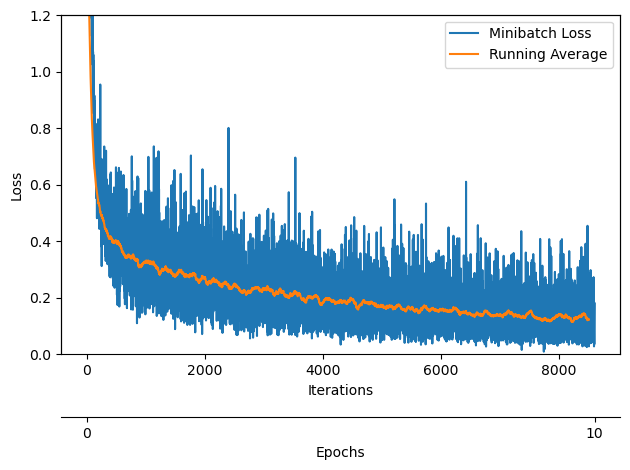

In [33]:
from helper_plotting import plot_training_loss

plot_training_loss(minibatch_loss_list=loss_list,
                   num_epochs=num_epochs,
                   iter_per_epoch=len(loss_list)//num_epochs)

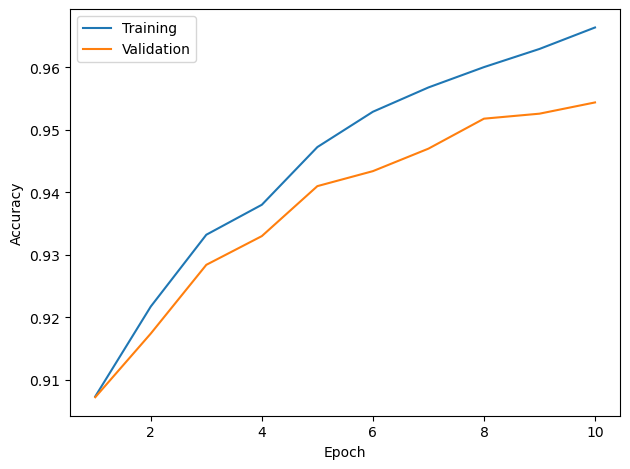

In [34]:
from helper_plotting import plot_accuracy

plot_accuracy(train_acc_list=train_acc_list, valid_acc_list=val_acc_list)